# **MCBS Final Project**
## Model 1: ResNeXt on AML data
Replication of Matek et al. (2019) paper aiming to train a ResNeXt-50 model for the task of recognition of blood cell subtypes in patients with or without AML.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import splitfolders
import shutil
import random
import sys
import os

Using TensorFlow backend.


In [3]:
# import custom modules 
import importlib
sys.path.append('../modules')

for cust in ['test_module','residual_network']:
    if cust in sys.modules:
        importlib.reload(sys.modules[cust])
        
import test_module as tm
from residual_network import residual_network

In [4]:
base_path  = "../data/aml"
orig_data_path = f"{base_path}/full"
data_path = f"{base_path}/full"
split_data_path = f"{base_path}/split"

classes_dictionary_org = {'BAS':0, 'EBO':1, 'EOS':2, 'KSC':3, 'LYA':4, 'LYT':5, 'MMZ':6, 'MOB':7, 'MON':8, 'MYB':9, 'MYO':10, 'NGB':11, 'NGS':12, 'PMB':13, 'PMO':14 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}


abbreviation_dict = { 'NGS':'Neutrophil (segmented)', 
                      'NGB':'Neutrophil (band)',
                      'EOS':'Eosinophil',
                      'BAS':'Basophil',
                      'MON':'Monocyte',
                      'LYT':'Lymphocyte (typical)',
                      'LYA':'Lymphocyte (atypical)',
                      'KSC':'Smudge Cell',
                      'MYO':'Myeloblast',
                      'PMO':'Promyelocyte',
                      'MYB':'Myelocyte',
                      'MMZ':'Metamyelocyte',
                      'MOB':'Monoblast',
                      'EBO':'Erythroblast',
                      'PMB':'Promyelocyte (bilobed)'}


img_width, img_height = 400, 400

if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
else:
        input_shape = (img_width, img_height, 3)

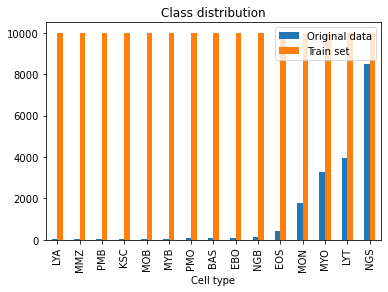

In [5]:
def get_number_of_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

data_dist = {}

for class_abbv, class_full in abbreviation_dict.items():
    data_dist[class_abbv] = [class_abbv,
                             get_number_of_files(f'{orig_data_path}/{class_abbv}')
                             ,get_number_of_files(f'{split_data_path}/train_aug10k/{class_abbv}')
                            ]
    
data_dist_df = pd.DataFrame.from_dict(data_dist, 'index', columns=['Cell type','Original data', 'Train set'])
data_dist_df['%']= data_dist_df['Original data']/data_dist_df['Original data'].sum()
data_dist_df.sort_values(by = "%", inplace=True)

data_dist_df.plot.bar(x= 'Cell type', y=['Original data', 'Train set'], title = "Class distribution")
plt.show()

### **Loading the data**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

input_size = (img_width, img_height)
batch_size = 16

train_set = datagen.flow_from_directory(f"{split_data_path}/train_aug10k/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size,
                                        )

val_set = datagen.flow_from_directory(f"{split_data_path}/val/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size, 
                                      batch_size = batch_size)

test_set = datagen.flow_from_directory(f"{split_data_path}/test/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size,
                                      shuffle=False)


Found 150021 images belonging to 15 classes.
Found 1828 images belonging to 15 classes.
Found 1850 images belonging to 15 classes.


# **Training**

An attempt of reproducing Matek et al. (2019) results - the AML data will be fed to a ResNeXt model in a manner similar to the one described in the original paper.

### **ResNeXt**

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam

sys.path.append('../scripts')
from  residual_network import residual_network

model = residual_network(15, (img_width, img_height, 3))

#weight_file_path = '../models/model_aml_orig/weights.hdf5'
#model.load_weights(weight_file_path)

In [108]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'], 
              )

In [8]:
model_nm = "model1_aml"

epoch_num = 20  # @param {type: "slider", min:1, max:100}

epoch_steps = train_set.samples//batch_size
val_steps = val_set.samples//batch_size

print("\tMODEL SUMMARY: \n")
print(f"Input shape:\t\t{model.inputs[0].shape}")
print(f"Output shape:\t\t{model.outputs[0].shape}\n")
print(f"Train set:\t\t{train_set.samples} images")
print(f"Test set:\t\t{test_set.samples} images")
print(f"Validation set:\t\t{val_set.samples} images\n")
print(f"Number of epochs:\t{epoch_num}")
print(f"Batch size:\t\t{batch_size}")
print(f"Steps per epoch:\t{epoch_steps}")
print(f"Validation steps:\t{val_steps}")

	MODEL SUMMARY: 

Input shape:		(None, 400, 400, 3)
Output shape:		(None, 15)

Train set:		150021 images
Test set:		1850 images
Validation set:		1828 images

Number of epochs:	20
Batch size:		16
Steps per epoch:	9376
Validation steps:	114


In [ ]:
history = model.fit(
        train_set,
        batch_size=batch_size,
        validation_data = val_set,
        validation_steps = val_steps,
        steps_per_epoch = epoch_steps,
        epochs = epoch_num)

In [193]:
tm.save_model(model, "model1_aml", history)

INFO:tensorflow:Assets written to: ../models/model1_aml/assets


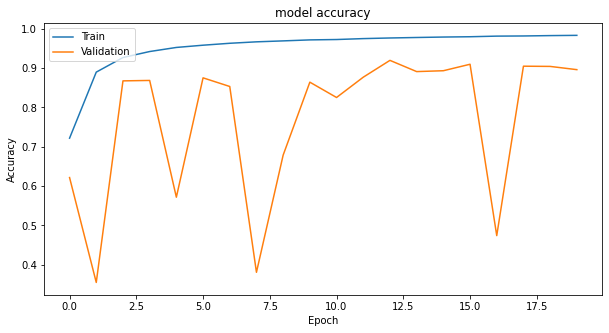

In [194]:
tm.plot_hist(history.history)

## **Model performance**

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras import models

Adjust class indices and prediction in order to present results per cell class in the same order as in the original paper.

In [8]:
paper_order = ['NGS','NGB','LYT','LYA','MON','EOS','BAS','MYO',
                       'PMO','PMB','MYB','MMZ','MOB','EBO','KSC']
paper_order_full = [abbreviation_dict[class_abbv] for class_abbv in paper_order]
adj_dict = {k:i for i,k in enumerate(paper_order)}

def adjust_class(class_id):
    return adj_dict[classes_dictionary[class_id]]

#class_id = 1
#print(f"Current position:{class_id}\nCell class: {abbreviation_dict[classes_dictionary[class_id]]}\nNew idx: {adjust_class(class_id)}")

In [10]:
#load weights and recompile model
model_name = "model1_aml"

model = models.load_model(f'../models/{model_name}/')

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'], 
              )

In [16]:
test_loss, test_acc, test_prec = model.evaluate(test_set)

116/116 [==============================] - 31s 270ms/step - loss: 0.4100 - accuracy: 0.9168 - precision: 0.9230


In [11]:
#get labels for the plots
labels = [abbreviation_dict[classes_dictionary[i]] for i in range(15)]

In [31]:
y_test = test_set.classes
y_pred_prob = model.predict(test_set)
y_pred = y_pred_prob.argmax(axis=1)

#reorder classes for easier comparison with the original results
adj_y_pred = [adjust_class(i) for i in y_pred]
adj_y_test = [adjust_class(i) for i in y_test]

In [47]:
pd.options.display.float_format = '{:,.2f}'.format

df = tm.CM_measures(confusion_matrix(y_test, y_pred), labels=labels)
df=df.reindex(paper_order_full)
df[['Precision','Sensitivity', 'Support']]

../modules/test_module.py:129: RuntimeWarning: invalid value encountered in true_divide
  cmdict['Precision'] = TP/(TP+FP)


,Precision,Sensitivity,Support
Neutrophil (segmented),0.98,0.91,849
Neutrophil (band),0.09,0.58,12
Lymphocyte (typical),0.98,0.92,395
Lymphocyte (atypical),0.00,0.00,2
Monocyte,0.93,0.83,180
Eosinophil,0.95,0.98,43
Basophil,0.50,0.78,9
Myeloblast,0.87,0.98,328
Promyelocyte,0.60,0.43,7
Promyelocyte (bilobed),0.40,0.67,3


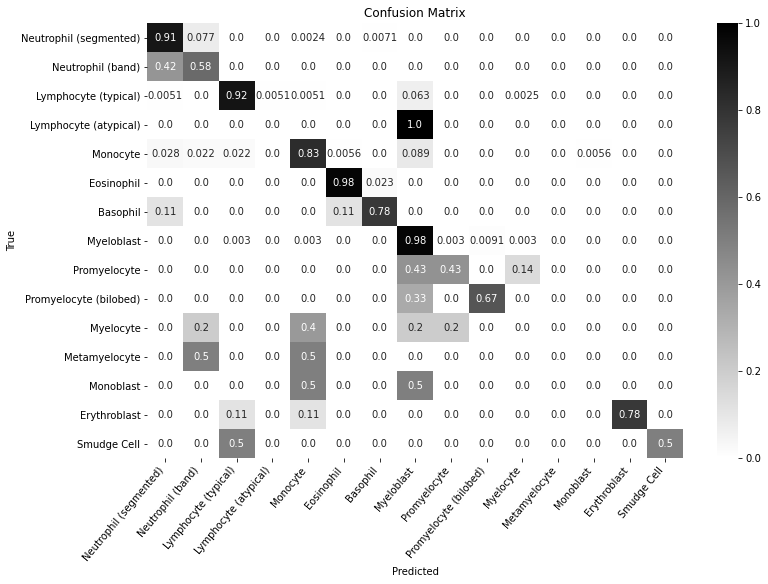

In [48]:
tm.plot_CM_heatmap(adj_y_test, adj_y_pred, paper_order_full, save=True, model_nm =model_name)

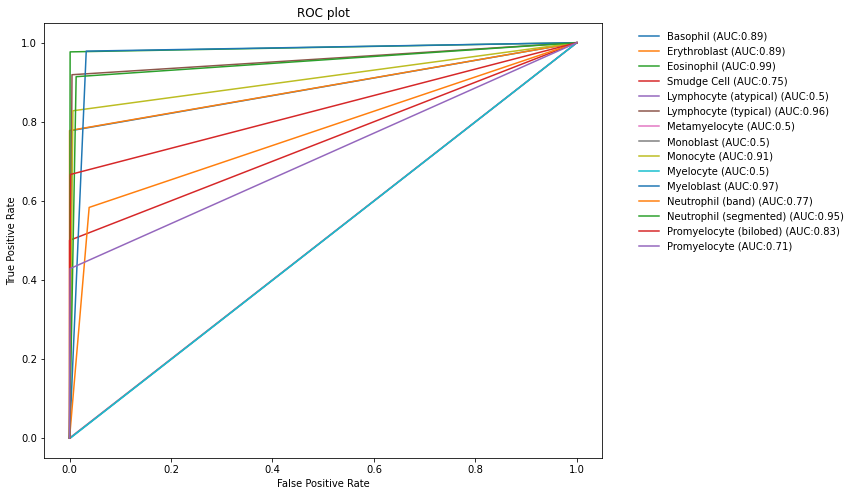

Macro AUC: 0.7747859171532542


In [49]:
tm.plot_multiclass_ROC(y_test, y_pred, labels, save=True, model_nm = model_name)

### **Blast/atypical clasification**

Evaluation of model's ability to recognize atypical and blast cells.

ATYPICAL cell types:
* Erythroblast
* Lymphocyte (atypical)
* Metamyelocyte
* Monocyte
* Myelocyte
* Myeloblast
* Promyelocyte (bilobed)
* Promyelocyte

BLAST cells:
* Monoblast
* Myeloblast

In [41]:
# cells possesing blast character
atypical_ids = [key for key, abbv in classes_dictionary.items() if abbv in ['MYO','MON', 'MYB','MMZ','PMO','PMB','LYA','EBO']]

# atypical cell types that occur in pathological situations, namely :myeloblasts, 
# monoblasts, myelocytes, metamyelocytes, promyelocytes, erythroblasts and
# atypical lymphocytes
blast_ids = [key for key, abbv in classes_dictionary.items() if abbv in ['MYO','MOB']]

In [32]:
def sum_for_ids(probs, indices):
  """ Returns a sum of probabilities with a given <indices> """
  return probs[:,indices].sum(axis=1)

atyp_prob = sum_for_ids(y_pred_prob, atypical_ids)
atyp_true = [1 if i in atypical_ids else 0 for i in y_test]

blast_prob = sum_for_ids(y_pred_prob, blast_ids)
blast_true = [1 if i in blast_ids else 0 for i in y_test]

AUC for atypical cells recognition: 0.9906617029010201
AUC for blast cells recognition: 0.9930552248519771


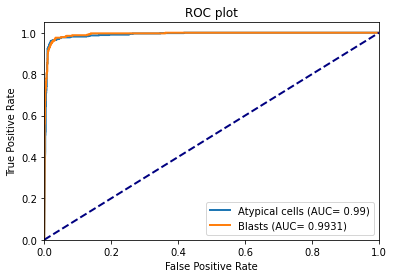

In [33]:
bfpr, btpr, bthresholds = roc_curve(blast_true, blast_prob)
blast_roc_auc = roc_auc_score(blast_true, blast_prob)

afpr, atpr, athresholds = roc_curve(atyp_true, atyp_prob)
atyp_roc_auc = roc_auc_score(atyp_true, atyp_prob)
print("AUC for atypical cells recognition:", atyp_roc_auc)
print("AUC for blast cells recognition:", blast_roc_auc)
          
plt.figure()
lw = 2
plt.plot(afpr, atpr, lw=lw, label='Atypical cells (AUC= %0.2f)' % atyp_roc_auc)
plt.plot(bfpr, btpr, lw=lw, label='Blasts (AUC= %0.4f)' % blast_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot')
plt.legend(loc="lower right")
plt.savefig(f"../figures/{model_name}_blast_atyp.png")
plt.show()

### **Examples of predictions**

In [34]:
import glob 
image_directory =f"{split_data_path}/test/"

files = glob.glob(f"{image_directory}/**/*")
images_list = []
orig_labels = []

for file in files:
    subdirectory, filename = file.split("/")[-2:]
    img1 = io.imread(file)
    img1 = (img1[:,:,:3] *1./255)
    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)
    orig_labels.append(classes_dictionary_org[subdirectory])
    images_list.append(x)

images = np.vstack(images_list)
preds_probs = model.predict(images, batch_size = 16)

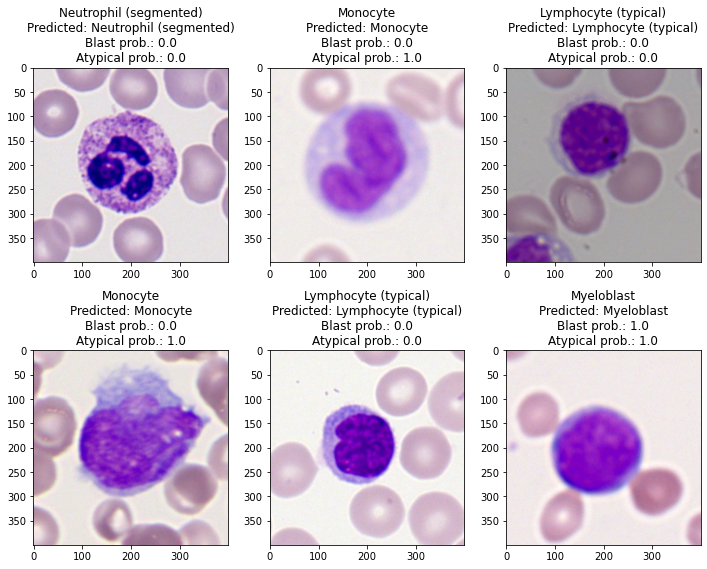

In [57]:
# display 8 images from the test sample along with 
# their predicted classes

indices = [random.randint(0,len(orig_labels)) for i in range(6)]

fig, axs = plt.subplots(2,3, figsize=(10,8))
fig.tight_layout() 

for n,idx in enumerate(indices):
    plt.subplot(2,3,n+1)
    orig  = orig_labels[idx]
    pred = preds_probs.argmax(axis=1)[idx]
    orig = abbreviation_dict[classes_dictionary[orig]]
    pred = abbreviation_dict[classes_dictionary[pred]]
    atypical = round(sum_for_ids(preds_probs, atypical_ids)[idx],2)
    blast = round(sum_for_ids(preds_probs, blast_ids)[idx],2)
    title = f"{orig}\nPredicted: {pred}\n" \
            f"Blast prob.: {blast:.2}\nAtypical prob.: {atypical:.2}"
    plt.title(title)
    plt.imshow(images[idx,:,:,:])

plt.savefig(f"../figures/{model_name}_examples.png")